In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
import cv2
import sklearn.metrics 
from pathlib import Path

In [2]:
class eye_dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
            return (image, mask)
        return image

In [3]:
def conv_layer(chanIn, chanOut, ks = 3, stride=1):
    return nn.Sequential(
        nn.Conv2d(chanIn, chanOut, ks, stride, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chanOut)
        )

class Conv_block(nn.Module):
    def __init__(self, chanIn, chanOut, pool = False):
        super().__init__()
        
        self.conv1 = conv_layer(chanIn, chanOut)
        self.conv2 = conv_layer(chanOut, chanOut)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        
class Mid_block(nn.Module):
    def __init__(self, chanIn, chanOut, ks=3, stride=1):
        super().__init__()        
        self.conv1 = nn.Conv2d(chanIn, chanOut, ks, padding=1)
        self.conv2 = nn.Conv2d(chanOut, chanOut, ks, padding=1)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
  

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.down1 = Conv_block(1,16)
        self.down2 = Conv_block(16, 32)
        self.down3 = Conv_block(32,64)
        self.down4 = Conv_block(64,128)
        
        self.mid = Mid_block(128,256)
        
        self.upt3 = nn.ConvTranspose2d(256,128,2,2)
        self.up3 =Conv_block(256,128)
        self.upt2 = nn.ConvTranspose2d(128, 64,2,2)
        self.up2 = Conv_block(128,64)
        self.upt1 = nn.ConvTranspose2d(64, 32,2,2)
        self.up1 = Conv_block(64,32)
        self.upt0 = nn.ConvTranspose2d(32, 16,2,2)
        self.up0 = Conv_block(32,16)
        self.last = nn.Conv2d(16,1,1)
        
        self.maxPool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(p=.25, inplace=True)
        
    
    def forward(self, x):
        x1 = self.down1(x)
        p1 = self.maxPool(x1)
        p1 = self.dropout(p1)
        
        x2 = self.down2(p1)
        p2 = self.maxPool(x2)
        p2 = self.dropout(p2)
        
        x3 = self.down3(p2)
        p3 = self.maxPool(x3)
        p3 = self.dropout(p3)
        
        x4 = self.down4(p3)
        p4 = self.maxPool(x4)
        p4 = self.dropout(p4)
        
        xmid = self.mid(p4)
        
        xu3 = self.upt3(xmid)
        cat3 = torch.cat([x4, xu3],1) #x4,xu3
        xu3 = self.up3(cat3)
        
        xu2 = self.upt2(xu3)
        cat2 = torch.cat([x3, xu2],1)
        xu2 = self.up2(cat2)
                
        xu1 = self.upt1(xu2)
        cat1 = torch.cat([x2,xu1],1)
        xu1 = self.up1(cat1)
        
        xu0 = self.upt0(xu1)
        cat0 = torch.cat([x1,xu0],1)
        xu0 = self.up0(cat0)
        return self.last(xu0)

In [4]:
test_path = Path('data/DRIVE/test/images_gray/')
test_mask = Path('data/DRIVE/test/1st_manual/')
test_img_names = []
test_mask_names = []
for test_img, test_mask in zip(test_path.iterdir(), test_mask.iterdir()):
    test_img_names.append(str(test_img))
    test_mask_names.append(str(test_mask))
test_img_names.sort()
test_mask_names.sort()

In [5]:
im_width = 560
im_height = 560

X_test = np.zeros((20, im_height, im_width, 1), dtype=np.uint8)

for i in tqdm_notebook(range(20)):
    
    #resize for test images
    test_img = imread(test_img_names[i])
    test_img = test_img[20:580,4:564]
    #test_img = resize(test_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    test_img = np.expand_dims(test_img, axis=2)
    X_test[i] = test_img

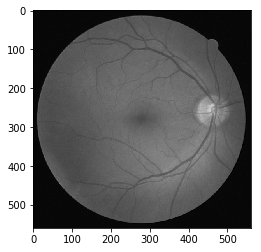

In [6]:
#resized images
ix = 9
plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
plt.show()
# tmp = np.squeeze(Y_train[ix]).astype(np.float32)
# plt.imshow(np.dstack((tmp,tmp,tmp)))
# plt.show()

In [7]:
X_test_shaped = X_test.reshape(-1,1, 560, 560)/255
X_test_shaped = X_test_shaped.astype(np.float32)

In [33]:
eye_test_dataset = eye_dataset(X_test_shaped[14:20], train=False)
test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=1,
                                         shuffle=False)

In [9]:
model = Unet()
model.cuda()
state_dict = torch.load('data/eyeResults/res_unetAgam_c180_1.pth')
model.load_state_dict(state_dict)
model.eval()

Unet(
  (down1): Conv_block(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down2): Conv_block(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down3): Conv_block(
    (conv1): Sequential(
      (0): Conv2d(32, 64,

In [34]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    #image = image.unsqueeze(0)
    y_pred = model(image)
    res.append(y_pred)


In [23]:
def res_show(img, idx):
    result = img.reshape(560,560,-1)
    result = result.data.cpu().numpy()
    result = np.squeeze(result>.3).astype(np.float32)*255
#     x = resize(result, (584, 565, 1), mode='constant', preserve_range=True)
#     x = np.squeeze(x).astype(np.float32)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(np.dstack((result,result,result)))
    
    topBorderWidth =20
    bottomBorderWidth =4
    leftBorderWidth =4
    rightBorderWidth=1
    outputImage = cv2.copyMakeBorder(
                 np.dstack((result,result,result)), 
                 topBorderWidth, 
                 bottomBorderWidth, 
                 leftBorderWidth, 
                 rightBorderWidth, 
                 cv2.BORDER_CONSTANT, 
                 value=0
              )
    
    path_res = 'data/DRIVE/res_1/'+str(idx)+'_res_mask.png'
    cv2.imwrite(path_res, outputImage)
    plt.show()
#res_show(res[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


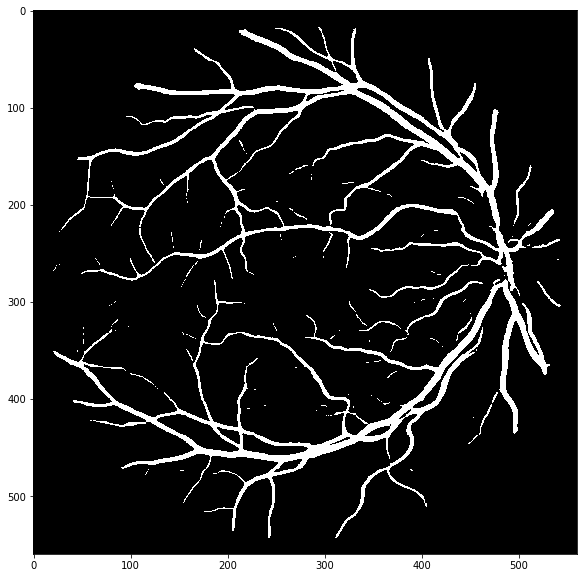

In [40]:
res_show(res[5][0],20)

In [138]:
img1 = cv2.imread('data/DRIVE/res_1/12_res_mask.png', cv2.IMREAD_GRAYSCALE)
true_img1 = cv2.imread('data/DRIVE/test/1st_manual/12_manual1.jpg', cv2.IMREAD_GRAYSCALE)
true_y = true_img1.flatten()
img_flat = img1.flatten()
plt.axes = figsize(10,10)
plt.imshow(img1)
img1.shape

NameError: name 'figsize' is not defined

In [134]:
for i in range(len(true_y)):
    if true_y[i] >100:
        true_y[i] =1
    else:
        true_y[i] =0
    if img_flat[i] >250:
        img_flat[i] =1
    else:
        img_flat[i] =0

In [135]:
count = 0
for i in range(len(true_y)):
    if true_y[i] == img_flat[i]:
        count +=1
print(count/len(true_y))

0.9704873317977937


In [136]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_y, img_flat, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [137]:
print(roc_auc)

0.8741025940249743
